# Multiple Linear Regression


## Import required packages

In [1]:
%matplotlib inline
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

import matplotlib.pylab as plt
import seaborn as sns

from dmba import regressionSummary, liftChart, gainsChart
from dmba import adjusted_r2_score, AIC_score, BIC_score

no display found. Using non-interactive Agg backend


### Kings County, WA (Seattle) House Price Data

In [49]:
kc_df = pd.read_csv('kc_house_data.csv')
kc_df.head(10)

,price,bedrooms,bathrooms,sqft living,sqft lot,floors,waterfront,view,condition,grade,sqft above,sqft basement,yr built,yr renovated,zipcode,lat,long,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,2015,2,18
5,1230000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,2014,5,12
6,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2014,6,27
7,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,2015,1,15
8,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,2015,4,15
9,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2015,3,12


In [50]:
# get rid of nonessential variables - which one(s)?
kc_df = kc_df.drop(columns=['day', 'lat', 'long'])

In [51]:
kc_df.columns = [s.strip().replace(' ', '_') for s in kc_df.columns]
kc_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'year',
       'month'],
      dtype='object')

In [52]:
kc_df.condition = kc_df.condition.astype('category')
kc_df.view = kc_df.view.astype('category')
kc_df.waterfront = kc_df.waterfront.astype('category')
kc_df.zipcode = kc_df.zipcode.astype('category')

In [6]:
# check the object types of the variables; how many categorical, integer, and floating point?
kc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null category
view             21613 non-null category
condition        21613 non-null category
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null category
lat              21613 non-null float64
long             21613 non-null float64
year             21613 non-null int64
month            21613 non-null int64
dtypes: category(4), float64(5), int64(10)
memory usage: 2.6 MB


In [6]:
pd.DataFrame({'mean': kc_df.mean(),
              'sd': kc_df.std(),
              'min': kc_df.min(),
              'max': kc_df.max(),
              'median': kc_df.median(),
              'length': len(kc_df),
              'miss.val': kc_df.isnull().sum(),
             })

,mean,sd,min,max,median,length,miss.val
price,540182.158793,367362.231718,75000.0000,7.700000e+06,450000.0000,21613,0
bedrooms,3.370842,0.930062,0.0000,3.300000e+01,3.0000,21613,0
bathrooms,2.114757,0.770163,0.0000,8.000000e+00,2.2500,21613,0
sqft_living,2079.899736,918.440897,290.0000,1.354000e+04,1910.0000,21613,0
sqft_lot,15106.967566,41420.511515,520.0000,1.651359e+06,7618.0000,21613,0
floors,1.494309,0.539989,1.0000,3.500000e+00,1.5000,21613,0
waterfront,0.007542,0.086517,0.0000,1.000000e+00,0.0000,21613,0
view,0.234303,0.766318,0.0000,4.000000e+00,0.0000,21613,0
condition,3.409430,0.650743,1.0000,5.000000e+00,3.0000,21613,0
grade,7.656873,1.175459,1.0000,1.300000e+01,7.0000,21613,0


[Text(0, 0.5, 'count'), Text(0.5, 0, 'Prices')]

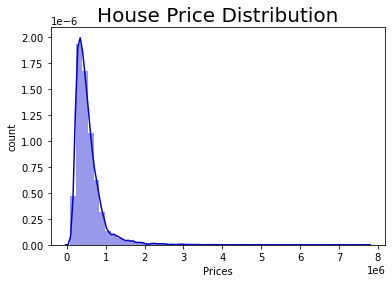

In [21]:
fig, ax = plt.subplots(1,1)

sns.distplot(kc_df.price, 
             bins=50, 
             label='Seattle House Prices', 
             color='mediumblue')

ax.set_title('House Price Distribution', fontsize=20)
ax.set(xlabel='Prices', ylabel='count')

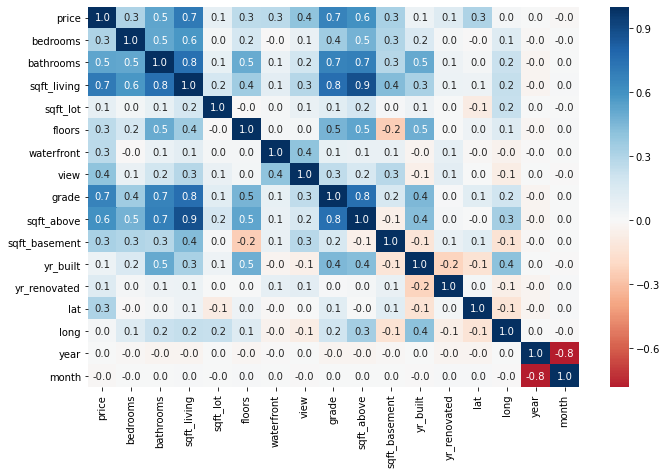

In [11]:
%matplotlib inline

# Check for collinearity
corr=kc_df.corr()

fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)

plt.show()

In [53]:
# isolate predictors separate from the response variable

X = kc_df.drop(columns=['price'])
y = kc_df['price']

In [7]:
X_exp = pd.get_dummies(X, prefix_sep="_", drop_first=True)

print(X_exp.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long', 'year', 'month',
       'condition_2', 'condition_3', 'condition_4', 'condition_5'],
      dtype='object')


In [8]:
X_exp.shape

(21613, 20)

In [9]:
# load the linear regression algorithm into an object called "data_lm"
data_lm = LinearRegression()

# fit the linear regression algorithm object to the entire dataset, thus creating an explanatory model
explanatory_model = data_lm.fit(X_exp, y)

In [10]:
# print coefficients from the explanatory model
print('intercept ', explanatory_model.intercept_)

print(pd.DataFrame({'Predictor': X_exp.columns, 'coefficient': explanatory_model.coef_}))

intercept  -111409875.39938548
        Predictor    coefficient
0        bedrooms  -33861.347079
1       bathrooms   41767.938483
2     sqft_living     114.148673
3        sqft_lot      -0.070188
4          floors   -1208.928404
5      waterfront  582597.814123
6            view   51569.773842
7           grade  103308.225167
8      sqft_above      75.719321
9   sqft_basement      38.429352
10       yr_built   -2426.967332
11   yr_renovated      22.056466
12            lat  568763.554312
13           long -103126.095672
14           year   37693.444058
15          month    1394.902977
16    condition_2  -10656.640764
17    condition_3  -35659.046796
18    condition_4   -1901.080127
19    condition_5   36039.844247


In [11]:
# Print out the measures of model fit

pred_y = explanatory_model.predict(X_exp)

print('adjusted r2 : ', adjusted_r2_score(y, pred_y, explanatory_model))
print('AIC : ', AIC_score(y, pred_y, data_lm))
print('BIC : ', BIC_score(y, pred_y, data_lm))


adjusted r2 :  0.6957412694938332
AIC :  589543.6626918082
BIC :  589719.2457976268


In [54]:
X = pd.get_dummies(X, prefix_sep="_", drop_first=True)

In [55]:
X.shape

(21613, 90)

In [56]:
# partition the data into training and test sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.5, random_state=1)

In [46]:
import category_encoders as ce

encoder = ce.CatBoostEncoder()

train_X = encoder.fit_transform(train_X, train_y)
test_X = encoder.fit_transform(test_X, test_y)

In [57]:
# load the linear regression algorithm into an object called "data_lm"
data_lm = LinearRegression()

# fit the linear regression algorithm object to the training data, thus creating a model
model = data_lm.fit(train_X, train_y)

In [58]:
# print performance measures of the training data

regressionSummary(train_y, model.predict(train_X))
print()
regressionSummary(test_y, model.predict(test_X))


Regression statistics

                      Mean Error (ME) : -0.0202
       Root Mean Squared Error (RMSE) : 151453.5362
            Mean Absolute Error (MAE) : 92676.9341
          Mean Percentage Error (MPE) : -1.0204
Mean Absolute Percentage Error (MAPE) : 19.0643


Regression statistics

                      Mean Error (ME) : 995.3517
       Root Mean Squared Error (RMSE) : 168145.5749
            Mean Absolute Error (MAE) : 96295.8656
          Mean Percentage Error (MPE) : -0.5336
Mean Absolute Percentage Error (MAPE) : 19.6343


0.905894327750532


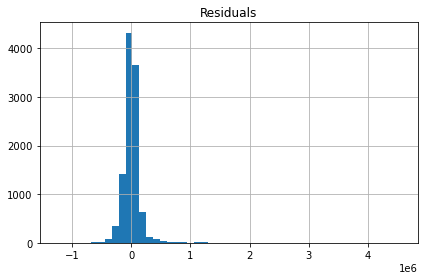

In [31]:
# Display a histogram of the residuals to determine whether to use RMSE or MAE

%matplotlib inline

kc_lm_pred = model.predict(test_X)
all_residuals = test_y - kc_lm_pred

# Determine the percentage of datapoints with a residual in [-200000, 200000] = approx. 75\%
print(len(all_residuals[(all_residuals > -200000) & (all_residuals < 200000)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=50)

plt.tight_layout()
plt.show()

In [32]:
# Checking residuals by sample in the test data

model_pred = model.predict(test_X)

result = pd.DataFrame({'Predicted': model_pred, 'Actual': test_y,
                       'Residual': test_y - model_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(test_y, model_pred)

          Predicted     Actual       Residual
15544  5.380827e+05   459000.0  -79082.650559
17454  3.685400e+05   445000.0   76460.026533
21548  7.069524e+05  1060000.0  353047.630585
3427   6.597166e+05   732350.0   72633.387185
8809   2.040730e+05   235000.0   30927.015336
3294   6.619951e+05   555000.0 -106995.148684
275    4.869692e+05   365000.0 -121969.170615
8736   7.932878e+05   685000.0 -108287.811857
6161   5.567319e+05   525000.0  -31731.898778
19832  5.115991e+05   449950.0  -61649.069428
17232  3.181527e+05   280000.0  -38152.737189
1305   4.474274e+05   428000.0  -19427.353378
12702  5.673702e+05   575000.0    7629.770707
12717  3.345247e+05   313100.0  -21424.692811
17327  5.761166e+05   637500.0   61383.384052
8196   1.075326e+06   732000.0 -343326.193737
13     3.655025e+05   400000.0   34497.525899
13412  7.567975e+05   829000.0   72202.495532
16484  4.401084e+05   469500.0   29391.646865
14761  6.401532e+05   537000.0 -103153.245742

Regression statistics

          

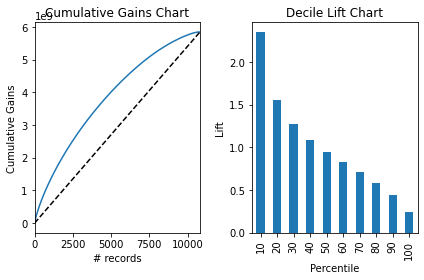

In [33]:
# Gain and lift charts for inspecting model goodness of fit

pred_v = pd.Series(model.predict(test_X))
pred_v = pred_v.sort_values(ascending=False)

fig,axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(pred_v, ax=axes[0])
ax.set_ylabel('Cumulative Gains')
ax.set_title("Cumulative Gains Chart")

ax = liftChart(pred_v, ax=axes[1], labelBars=False)
ax.set_ylabel("Lift")

plt.tight_layout()
plt.show()